In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, CuDNNLSTM, CuDNNGRU, BatchNormalization, LocallyConnected2D, Permute, TimeDistributed, Bidirectional
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
from keras.utils.generic_utils import Progbar
from keras.layers.merge import _Merge
import keras.losses
from keras.datasets import mnist

from functools import partial

from collections import defaultdict

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()

class EpochVariableCallback(Callback) :
    
    def __init__(self, my_variable, my_func) :
        self.my_variable = my_variable       
        self.my_func = my_func
        
    def on_epoch_begin(self, epoch, logs={}) :
        K.set_value(self.my_variable, self.my_func(K.get_value(self.my_variable), epoch))


Using TensorFlow backend.


In [2]:
#Load MNIST data

dataset_name = "mnist_3_vs_5"

img_rows, img_cols = 28, 28

num_classes = 10
batch_size = 32

included_classes = { 3, 5 }

(x_train, y_train), (x_test, y_test) = mnist.load_data()

keep_index_train = []
for i in range(y_train.shape[0]) :
    if y_train[i] in included_classes :
        keep_index_train.append(i)

keep_index_test = []
for i in range(y_test.shape[0]) :
    if y_test[i] in included_classes :
        keep_index_test.append(i)

x_train = x_train[keep_index_train]
x_test = x_test[keep_index_test]
y_train = y_train[keep_index_train]
y_test = y_test[keep_index_test]

n_train = int((x_train.shape[0] // batch_size) * batch_size)
n_test = int((x_test.shape[0] // batch_size) * batch_size)
x_train = x_train[:n_train]
x_test = x_test[:n_test]
y_train = y_train[:n_train]
y_test = y_test[:n_test]


x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print("x_train.shape = " + str(x_train.shape))

print("n train samples = " + str(x_train.shape[0]))
print("n test samples = " + str(x_test.shape[0]))

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

#Binarize images

def _binarize_images(x, val_thresh=0.5) :
    
    x_bin = np.zeros(x.shape)
    x_bin[x >= val_thresh] = 1.
    
    return x_bin

x_train = _binarize_images(x_train, val_thresh=0.5)
x_test = _binarize_images(x_test, val_thresh=0.5)


x_train.shape = (11552, 28, 28, 1)
n train samples = 11552
n test samples = 1888


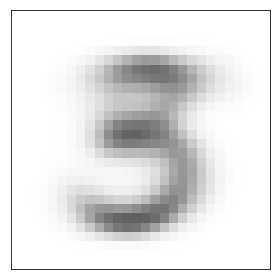

In [3]:
#Visualize background image distribution

pseudo_count = 1.0

x_mean = (np.sum(x_train, axis=(0, 3)) + pseudo_count) / (x_train.shape[0] + pseudo_count)
x_mean_logits = np.log(x_mean / (1. - x_mean))

f = plt.figure(figsize=(4, 4))

plot_ix = 0

plt.imshow(x_mean, cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

plt.xticks([], [])
plt.yticks([], [])

plt.tight_layout()
plt.show()


In [4]:
from tensorflow.python.framework import ops

#Stochastic Binarized Neuron helper functions (Tensorflow)
#ST Estimator code adopted from https://r2rt.com/binary-stochastic-neurons-in-tensorflow.html
#See Github https://github.com/spitis/

def bernoulli_sample(x):
    g = tf.get_default_graph()
    with ops.name_scope("BernoulliSample") as name:
        with g.gradient_override_map({"Ceil": "Identity","Sub": "BernoulliSample_ST"}):
            return tf.ceil(x - tf.random_uniform(tf.shape(x)), name=name)

@ops.RegisterGradient("BernoulliSample_ST")
def bernoulliSample_ST(op, grad):
    return [grad, tf.zeros(tf.shape(op.inputs[1]))]


In [5]:
#Masking and Sampling helper functions

def sample_image_st(x) :
    p = tf.sigmoid(x)

    return bernoulli_sample(p)

#Generator helper functions
def initialize_templates(generator, background_matrices) :

    embedding_backgrounds = []

    for k in range(len(background_matrices)) :
        embedding_backgrounds.append(background_matrices[k].reshape(1, -1))

    embedding_backgrounds = np.concatenate(embedding_backgrounds, axis=0)

    generator.get_layer('background_dense').set_weights([embedding_backgrounds])
    generator.get_layer('background_dense').trainable = False

#Generator construction function
def build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=1) :

    #Initialize Reshape layer
    reshape_layer = Reshape((n_rows, n_cols, 1))
    
    #Initialize background matrix
    background_dense = Embedding(n_classes, n_rows * n_cols, embeddings_initializer='zeros', name='background_dense')

    #Initialize Templating and Masking Lambda layer
    background_layer = Lambda(lambda x: x[0] + x[1], name='background_layer')
    
    #Initialize Sigmoid layer
    image_layer = Lambda(lambda x: K.sigmoid(x), name='image')
    
    #Initialize Sampling layers
    upsampling_layer = Lambda(lambda x: K.tile(x, [n_samples, 1, 1, 1]), name='upsampling_layer')
    sampling_layer = Lambda(sample_image_st, name='image_sampler')
    permute_layer = Lambda(lambda x: K.permute_dimensions(K.reshape(x, (n_samples, batch_size, n_rows, n_cols, 1)), (1, 0, 2, 3, 4)), name='permute_layer')
    
    def _sampler_func(class_input, raw_logits) :
        
        #Get Template and Mask
        background = reshape_layer(background_dense(class_input))
        
        #Add Template and Multiply Mask
        image_logits = background_layer([raw_logits, background])
        
        #Compute Image (Sigmoids from logits)
        image = image_layer(image_logits)
        
        #Tile each image to sample from and create sample axis
        image_logits_upsampled = upsampling_layer(image_logits)
        sampled_image = sampling_layer(image_logits_upsampled)
        sampled_image = permute_layer(sampled_image)
        
        return image_logits, image, sampled_image
    
    return _sampler_func


In [6]:
#Initialize Encoder and Decoder networks
batch_size = 32
n_rows = 28
n_cols = 28
n_samples = 128

#Load sampler
sampler = build_sampler(batch_size, n_rows, n_cols, n_classes=1, n_samples=n_samples)


In [7]:
#Load Predictor
predictor_path = 'saved_models/mnist_binarized_cnn_10_digits.h5'

predictor = load_model(predictor_path)

predictor.trainable = False
predictor.compile(optimizer=keras.optimizers.SGD(lr=0.1), loss='mean_squared_error')


In [8]:
#Build scrambler model
dummy_class = Input(shape=(1,), name='dummy_class')
input_logits = Input(shape=(n_rows, n_cols, 1), name='input_logits')

image_logits, image, sampled_image = sampler(dummy_class, input_logits)

scrambler_model = Model([input_logits, dummy_class], [image_logits, image, sampled_image])

#Initialize Templates and Masks
initialize_templates(scrambler_model, [x_mean_logits])

scrambler_model.trainable = False
scrambler_model.compile(
    optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999),
    loss='mean_squared_error'
)


In [9]:
scrambler_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dummy_class (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
background_dense (Embedding)    (None, 1, 784)       784         dummy_class[0][0]                
__________________________________________________________________________________________________
input_logits (InputLayer)       (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 28, 1)    0           background_dense[0][0]           
__________________________________________________________________________________________________
background

In [10]:

file_names = [
    "autoscrambler_dataset_mnist_3_vs_5_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_0005_kl_divergence_higher_entropy_penalty_importance_scores_test.npy",
    "autoscrambler_dataset_mnist_3_vs_5_inverted_scores_n_samples_32_resnet_5_4_32_3_00_n_epochs_50_target_bits_03_kl_divergence_higher_entropy_penalty_importance_scores_test.npy",
    "perturbation_dense_mnist_3_vs_5_importance_scores_test.npy",
    "deeplift_mnist_3_vs_5_method_gradient_importance_scores_test.npy",
    "deeplift_mnist_3_vs_5_method_guided_backprop_importance_scores_test.npy",
    "deeplift_mnist_3_vs_5_method_revealcancel_importance_scores_test.npy",
    "deepshap_mnist_3_vs_5_importance_scores_test.npy",
    "deeplift_mnist_3_vs_5_method_integrated_gradients_importance_scores_test.npy"
]

model_names =[
    "scrambler",
    "scrambler_inverted",
    "perturbation",
    "gradient",
    "guided_backprop",
    "deeplift",
    "deepshap",
    "integrated_gradients"
]

model_importance_scores_test = [np.load(file_name) for file_name in file_names]


In [11]:

feature_quantiles = [0.80, 0.90, 0.95, 0.98]

on_state_logit_val = 50.

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

digit_test = np.argmax(y_test, axis=-1)

y_pred_ref = predictor.predict([x_test], batch_size=32, verbose=True)

model_kl_divergences = []

for model_i in range(len(model_names)) :
    
    print("Benchmarking model '" + str(model_names[model_i]) + "'...")
    
    feature_quantile_kl_divergences = []
    
    for feature_quantile in feature_quantiles :
        
        print("Feature quantile = " + str(feature_quantile))
    
        importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
        quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

        top_logits_test = np.zeros(importance_scores_test.shape)
        top_logits_test[importance_scores_test <= quantile_vals] = on_state_logit_val
        
        top_logits_test = top_logits_test * x_test_logits

        _, _, samples_test = scrambler_model.predict([top_logits_test, dummy_test], batch_size=batch_size)

        mean_kl_divs = []
        for data_ix in range(samples_test.shape[0]) :

            if data_ix % 100 == 0 :
                print("Processing example " + str(data_ix) + "...")

            y_pred_var_samples = predictor.predict([samples_test[data_ix, ...]], batch_size=n_samples)
            y_pred_ref_samples = np.tile(np.expand_dims(y_pred_ref[data_ix, :], axis=0), (n_samples, 1))

            kl_divs = np.sum(y_pred_ref_samples * np.log(y_pred_ref_samples / y_pred_var_samples), axis=-1)
            
            #kl_divs = (y_pred_ref_samples[:, digit_test[data_ix]] - np.mean(y_pred_ref_samples, axis=-1)) - (y_pred_var_samples[:, digit_test[data_ix]] - np.mean(y_pred_var_samples, axis=-1))
            
            mean_kl_div = np.mean(kl_divs)

            mean_kl_divs.append(mean_kl_div)

        mean_kl_divs = np.array(mean_kl_divs)
        
        feature_quantile_kl_divergences.append(mean_kl_divs)

    model_kl_divergences.append(feature_quantile_kl_divergences)


1888/1888 [==============================] - 1s 671us/step
Benchmarking model 'scrambler'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...
Feature quantile = 0.9
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 13

Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...
Benchmarking model 'guided_backprop'...
Feature quantile = 0.8
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...
Feature quantile = 0.9
Processing exa

Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...
Feature quantile = 0.98
Processing example 0...
Processing example 100...
Processing example 200...
Processing example 300...
Processing example 400...
Processing example 500...
Processing example 600...
Processing example 700...
Processing example 800...
Processing example 900...
Processing example 1000...
Processing example 1100...
Processing example 1200...
Processing example 1300...
Processing example 1400...
Processing example 1500...
Processing example 1600...
Processing example 1700...
Processing example 1800...


In [12]:
model_names =[
    "scrambler",
    "scrambler\n(inverted)",
    "perturbation",
    "gradient",
    "guided\nbackprop",
    "deeplift",
    "deepshap",
    "integrated\ngradients"
]

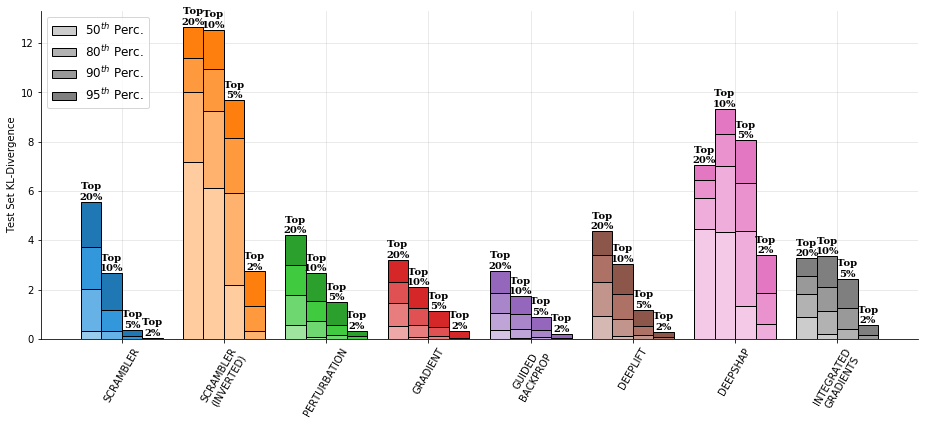

In [13]:
def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

fig = plt.figure(figsize=(13, 6))

benchmark_name = "benchmark_ablation_mnist"

save_figs = True

width = 0.2

max_y_val = 4.0

cm = plt.get_cmap('viridis_r')

shades = [0.4, 0.6, 0.8, 1]

quantiles = [0.5, 0.8, 0.9, 0.95]

all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] + plt.rcParams['axes.prop_cycle'].by_key()['color']
model_colors = {model_names[i]: all_colors[i] for i in range(len(model_names))}

results = np.zeros((len(quantiles), len(model_names), 1))

for i in range(1, len(feature_quantiles) + 1) :
    for j in range(len(model_names)):
        kl_div_samples = model_kl_divergences[j][i-1]

        for l in range(len(quantiles)):
            quantile = quantiles[l]

            results[l, j, 0] = np.quantile(kl_div_samples, q=quantile)

    xs = range(len(model_names))
    xs = [xi + i*width for xi in xs]
    
    for j in range(len(model_names)) :
        for l in range(len(quantiles)) :
            model_name = model_names[j]
            c = model_colors[model_name]
            val = results[l, j, 0]
            
            if i == 1 and j == 0 :
                lbl = "$%i^{th}$ Perc." % int(100*quantiles[l])
            else :
                lbl=None
            
            if l == 0 :
                plt.bar(xs[j], val, width=width, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
            else :
                prev_val = results[l-1, j].mean(axis=-1)
                plt.bar(xs[j],val-prev_val, width=width, bottom = prev_val, color=lighten_color(c, shades[l]), edgecolor='k', linewidth=1, label=lbl, zorder=l+1)
    
            if l == len(quantiles) - 1 :
                plt.text(xs[j], val, "Top\n" + str(int(100 - 100 * feature_quantiles[i-1])) + "%", horizontalalignment='center', verticalalignment='bottom', fontdict={ 'family': 'serif', 'color':  'black', 'weight': 'bold', 'size': 10 })
    
    prev_results = results

plt.xticks([i + 2.5*width for i in range(len(model_names))])

all_lbls = [model_names[j].upper() for j in range(len(model_names))]
plt.gca().set_xticklabels(all_lbls, rotation=60)

plt.ylabel("Test Set KL-Divergence")

max_y_val = np.max(results) * 1.1

#plt.ylim([0, max_y_val])

plt.grid(True)
plt.gca().set_axisbelow(True)
plt.gca().grid(color='gray', alpha=0.2)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.legend(fontsize=12, frameon=True, loc='upper left')
leg = plt.gca().get_legend()
for l in range(len(quantiles)):
    leg.legendHandles[l].set_color(lighten_color(all_colors[7], shades[l]))
    leg.legendHandles[l].set_edgecolor('k')

plt.tight_layout()

if save_figs :
    plt.savefig(benchmark_name + ".png", dpi=300, transparent=True)
    plt.savefig(benchmark_name + ".eps")

plt.show()


Test pattern = 3:
 - Prediction (original) = 1.0
Model = 'scrambler'...
 - Prediction (scrambled qts) = ['1.0', '1.0', '1.0', '1.0']
 - Prediction (scrambled natural) = 1.0


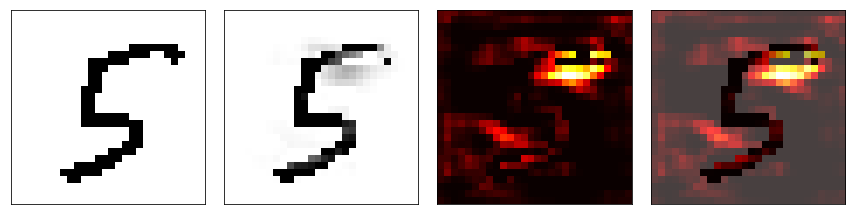

Model = 'scrambler
(inverted)'...
 - Prediction (scrambled qts) = ['0.27', '0.49', '0.86', '1.0']
 - Prediction (scrambled natural) = 0.43


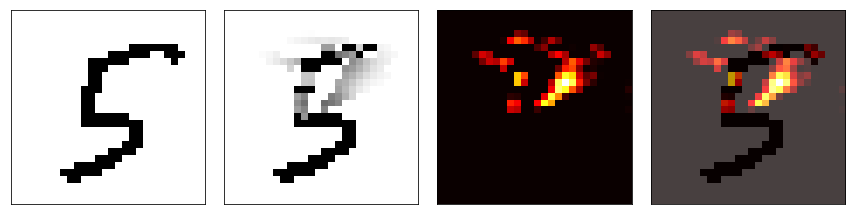

Model = 'perturbation'...
 - Prediction (scrambled qts) = ['0.96', '1.0', '1.0', '1.0']


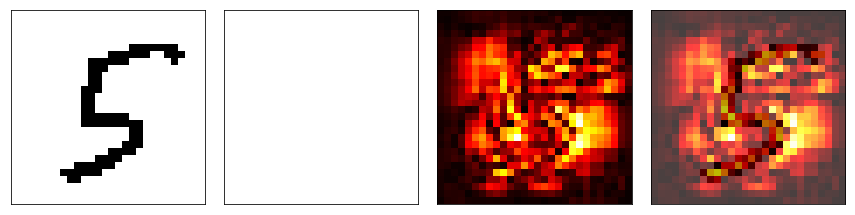

Model = 'gradient'...
 - Prediction (scrambled qts) = ['0.97', '1.0', '1.0', '1.0']


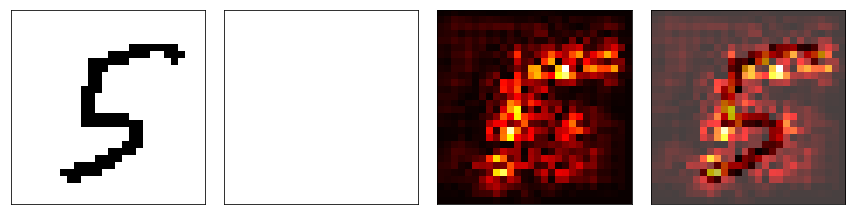

Model = 'guided
backprop'...
 - Prediction (scrambled qts) = ['0.99', '1.0', '1.0', '1.0']


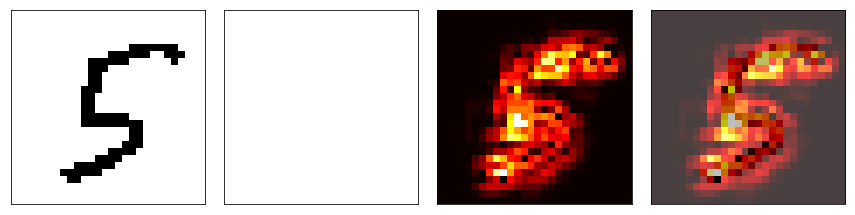

Model = 'deeplift'...
 - Prediction (scrambled qts) = ['0.91', '1.0', '1.0', '1.0']


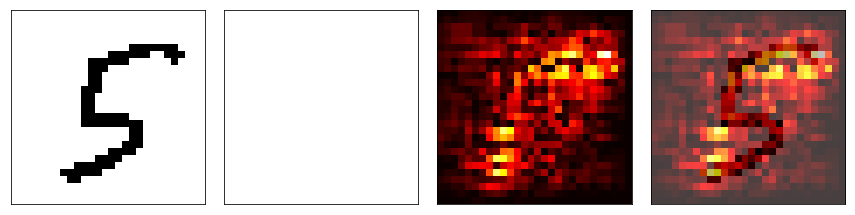

Model = 'deepshap'...
 - Prediction (scrambled qts) = ['0.26', '0.54', '1.0', '1.0']


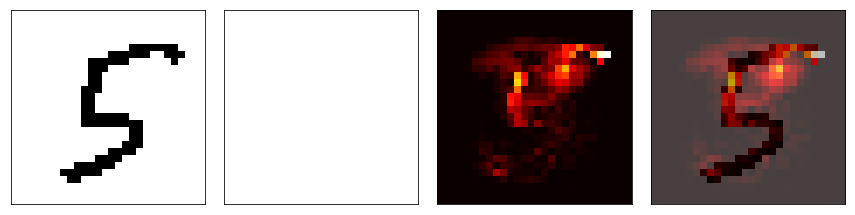

Model = 'integrated
gradients'...
 - Prediction (scrambled qts) = ['0.86', '0.93', '1.0', '1.0']


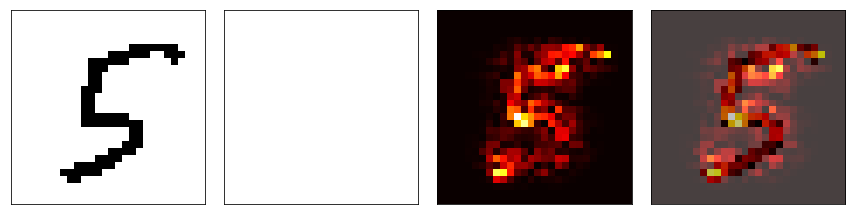

Test pattern = 4:
 - Prediction (original) = 1.0
Model = 'scrambler'...
 - Prediction (scrambled qts) = ['0.79', '0.97', '1.0', '1.0']
 - Prediction (scrambled natural) = 0.98


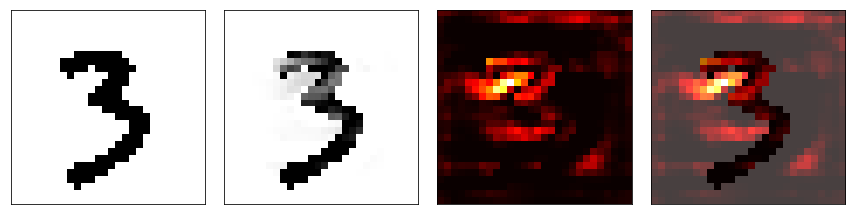

Model = 'scrambler
(inverted)'...
 - Prediction (scrambled qts) = ['0.16', '0.23', '0.28', '0.99']
 - Prediction (scrambled natural) = 0.25


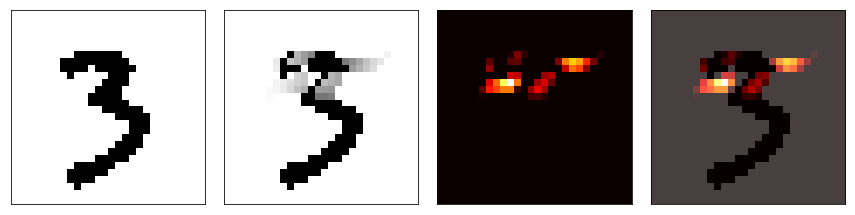

Model = 'perturbation'...
 - Prediction (scrambled qts) = ['0.67', '0.81', '0.98', '1.0']


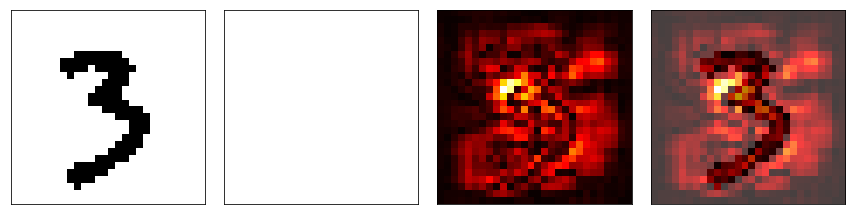

Model = 'gradient'...
 - Prediction (scrambled qts) = ['0.88', '0.99', '1.0', '1.0']


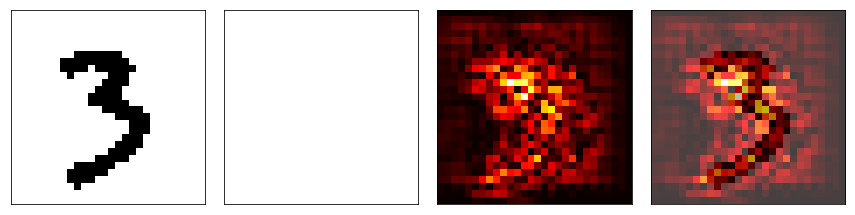

Model = 'guided
backprop'...
 - Prediction (scrambled qts) = ['0.85', '0.98', '1.0', '1.0']


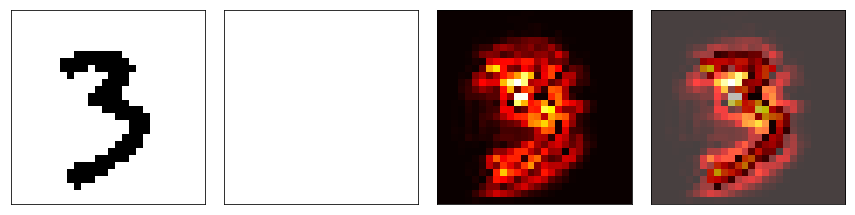

Model = 'deeplift'...
 - Prediction (scrambled qts) = ['0.78', '0.95', '1.0', '1.0']


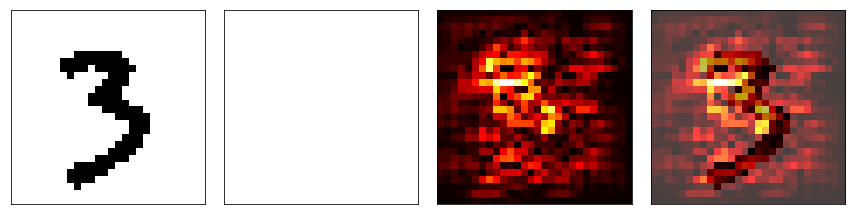

Model = 'deepshap'...
 - Prediction (scrambled qts) = ['0.08', '0.14', '0.64', '1.0']


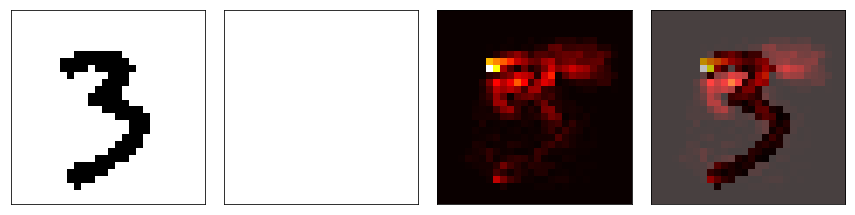

Model = 'integrated
gradients'...
 - Prediction (scrambled qts) = ['0.73', '0.98', '1.0', '1.0']


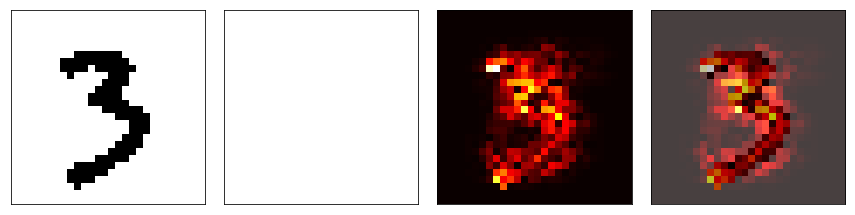

In [14]:
#Visualize a few example patterns

save_figs = True

from numpy.ma import masked_array

digit_test = np.argmax(y_test, axis=1)

plot_examples = [3, 4]

feature_quantiles = [0.80, 0.90, 0.95, 0.98]

on_state_logit_val = 50.

dummy_test = np.zeros((x_test.shape[0], 1))
x_test_logits = 2. * x_test - 1.

for data_ix in plot_examples :
    
    print("Test pattern = " + str(data_ix) + ":")

    y_test_hat_ref = predictor.predict(x=[np.expand_dims(x_test[data_ix], axis=0)], batch_size=1)[0, digit_test[data_ix]]
    
    print(" - Prediction (original) = " + str(round(y_test_hat_ref, 2))[:4])
    
    for model_i in range(len(model_names)) :

        print("Model = '" + str(model_names[model_i]) + "'...")

        if len(model_importance_scores_test[model_i].shape) >= 5 :
            importance_scores_test = np.abs(model_importance_scores_test[model_i][1, ...])
        else :
            importance_scores_test = np.abs(model_importance_scores_test[model_i])
        
        importance_scores_test = importance_scores_test[:32]
        
        y_test_hat_mean_qts = []
        for feature_quantile_i, feature_quantile in enumerate(feature_quantiles) :

            quantile_vals = np.quantile(importance_scores_test, axis=(1, 2, 3), q=feature_quantile, keepdims=True)
            quantile_vals = np.tile(quantile_vals, (1, importance_scores_test.shape[1], importance_scores_test.shape[2], importance_scores_test.shape[3]))

            top_logits_test = np.zeros(importance_scores_test.shape)
            top_logits_test[importance_scores_test <= quantile_vals] = on_state_logit_val

            top_logits_test = top_logits_test * x_test_logits[:32]

            _, _, samples_test = scrambler_model.predict([top_logits_test, dummy_test[:32]], batch_size=batch_size)
            
            y_test_hat = predictor.predict([samples_test[data_ix, ...]], batch_size=n_samples)[:, digit_test[data_ix]]
            y_test_hat_mean = np.mean(y_test_hat)

            y_test_hat_mean_qts.append(str(round(y_test_hat_mean, 2))[:4])

        print(" - Prediction (scrambled qts) = " + str(y_test_hat_mean_qts))
        
        image_test, samples_test = None, None
        
        if 'scrambler' in model_names[model_i] :
            
            scrambled_logits_test = (1. / np.maximum(importance_scores_test[:32], 1e-7)) * x_test_logits[:32]
            
            _, image_test, samples_test = scrambler_model.predict_on_batch([scrambled_logits_test, dummy_test[:32]])

            y_test_hat = predictor.predict([samples_test[data_ix, ...]], batch_size=n_samples)[:, digit_test[data_ix]]
            y_test_hat_mean = np.mean(y_test_hat)

            print(" - Prediction (scrambled natural) = " + str(round(y_test_hat_mean, 2))[:4])
            
        else :
            
            image_test = np.zeros(importance_scores_test.shape)
            samples_test = np.zeros(importance_scores_test.shape)
            
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(3 * 4, 3))

        ax1.imshow(x_test[data_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        plt.sca(ax1)
        plt.xticks([], [])
        plt.yticks([], [])

        ax2.imshow(image_test[data_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        plt.sca(ax2)
        plt.xticks([], [])
        plt.yticks([], [])

        ax3.imshow(importance_scores_test[data_ix, :, :, 0], cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[data_ix, :, :, 0]), aspect='equal')

        plt.sca(ax3)
        plt.xticks([], [])
        plt.yticks([], [])

        ax4.imshow(x_test[data_ix, :, :, 0], cmap="Greys", vmin=0.0, vmax=1.0, aspect='equal')

        plt.sca(ax4)
        plt.xticks([], [])
        plt.yticks([], [])

        ax4.imshow(importance_scores_test[data_ix, :, :, 0], alpha=0.75, cmap="hot", vmin=0.0, vmax=np.max(importance_scores_test[data_ix, :, :, 0]), aspect='equal')

        plt.sca(ax4)
        plt.xticks([], [])
        plt.yticks([], [])

        plt.tight_layout()

        if save_figs :
            plt.savefig("benchmark_ablation_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i].replace("\n", "_").replace("(", "").replace(")", "") + ".png", transparent=True, dpi=300)
            plt.savefig("benchmark_ablation_" + dataset_name + "_test_ix_" + str(data_ix) + "_" + model_names[model_i].replace("\n", "_").replace("(", "").replace(")", "") + ".eps")

        plt.show()
        